# Poisson equation

This demo is implemented in a single Python file, `demo_poisson.py`,
which contains both the variational forms and the solver. This Jupyter notebook has been created directly from
the FEniCS documented demo related to the Poisson equation (see [FEniCS Documentation][1])

[1]: https://fenicsproject.org/olddocs/dolfin/latest/python/demos/poisson/demo_poisson.py.html

This demo illustrates how to:

-   Solve a linear partial differential equation
-   Create and apply Dirichlet boundary conditions
-   Define Expressions
-   Define a FunctionSpace
-   Create a SubDomain

## Equation and problem definition

The Poisson equation is the canonical elliptic partial differential
equation. For a domain $\Omega \subset \mathbb{R}^n$ with boundary
$\partial \Omega = \Gamma_{D} \cup \Gamma_{N}$, the Poisson equation
with particular boundary conditions reads:

$$\begin{aligned}
- \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
\nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
\end{aligned}$$

Here, $f$ and $g$ are input data and $n$ denotes the outward directed
boundary normal. The most standard variational form of Poisson equation
reads: find $u \in V$ such that

$$a(u, v) = L(v) \quad \forall \ v \in V,$$

where $V$ is a suitable function space and

$$\begin{aligned}
a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
L(v)    &= \int_{\Omega} f v \, {\rm d} x
+ \int_{\Gamma_{N}} g v \, {\rm d} s.
\end{aligned}$$

The expression $a(u, v)$ is the bilinear form and $L(v)$ is the linear
form. It is assumed that all functions in $V$ satisfy the Dirichlet
boundary conditions $u = 0$ on $\Gamma_D$.

In this demo, we shall consider the following definitions of the input
functions, the domain, and the boundaries:

-   $\Omega = [0,1] \times [0,1]$ (a unit square)
-   $\Gamma_{D} = \{(0, y) \cup (1, y) \subset \partial \Omega\}$
    (Dirichlet boundary)
-   $\Gamma_{N} = \{(x, 0) \cup (x, 1) \subset \partial \Omega\}$
    (Neumann boundary)
-   $g = \sin(5x)$ (normal derivative)
-   $f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$ (source term)

## Implementation

This description goes through the implementation (in `demo_poisson.py`)
of a solver for the above described Poisson equation step-by-step.

First, the `dolfin` module is imported:

In [1]:
from dolfin import *

We begin by defining a mesh of the domain and a finite element function
space $V$ relative to this mesh. As the unit square is a very standard
domain, we can use a built-in mesh provided by the class
`UnitSquareMesh`. In order to create a
mesh consisting of 32 x 32 squares with each square divided into two
triangles, we do as follows :

In [2]:
# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)

The second argument to `FunctionSpace` is the finite element
family, while the third argument specifies the polynomial degree. Thus,
in this case, our space `V` consists of first-order, continuous Lagrange
finite element functions (or in order words, continuous piecewise linear
polynomials).

Next, we want to consider the Dirichlet boundary condition. A simple
Python function, returning a boolean, can be used to define the
subdomain for the Dirichlet boundary condition ($\Gamma_D$). The
function should return `True` for those points inside the subdomain and
`False` for the points outside. In our case, we want to say that the
points $(x, y)$ such that $x = 0$ or $x = 1$ are inside on the inside of
$\Gamma_D$. (Note that because of rounding-off errors, it is often wise
to instead specify $x <
\epsilon$ or $x > 1 - \epsilon$ where $\epsilon$ is a small number (such
as machine precision).) :

In [3]:
# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

Now, the Dirichlet boundary condition can be created using the class
`DirichletBC`. A
`DirichletBC` takes three arguments: the
function space the boundary condition applies to, the value of the
boundary condition, and the part of the boundary on which the condition
applies. In our example, the function space is `V`, the value of the
boundary condition (0.0) can represented using a
`Constant` and the Dirichlet
boundary is defined immediately above. The definition of the Dirichlet
boundary condition then looks as follows: :

In [4]:
# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

Next, we want to express the variational problem. First, we need to
specify the trial function $u$ and the test function $v$, both living in
the function space $V$. We do this by defining a
`TrialFunction` and a
`TestFunction` on the previously defined
`FunctionSpace` `V`.

Further, the source $f$ and the boundary normal derivative $g$ are
involved in the variational forms, and hence we must specify these. Both
$f$ and $g$ are given by simple mathematical formulas, and can be easily
declared using the
`Expression` class. Note
that the strings defining `f` and `g` use C++ syntax since, for
efficiency, DOLFIN will generate and compile C++ code for these
expressions at run-time.

With these ingredients, we can write down the bilinear form `a` and the
linear form `L` (using UFL operators). In summary, this reads :

In [5]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)
g = Expression("sin(5*x[0])", degree=2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx + g*v*ds

Now, we have specified the variational forms and can consider the
solution of the variational problem. First, we need to define a
`Function` `u` to represent the
solution. (Upon initialization, it is simply set to the zero function.)
A `Function` represents a function living in a
finite element function space. Next, we can call the :py`solve` function with the arguments `a == L`, `u` and `bc` as follows::

In [6]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


The function `u` will be modified during the call to solve. The default
settings for solving a variational problem have been used. However, the
solution process can be controlled in much more detail if desired.

A `Function` can be manipulated
in various ways, in particular, it can be plotted and saved to file.
Here, we output the solution to a `VTK` file (using the suffix `.pvd`)
for later visualization and also plot it using the
:py`plot` command: :

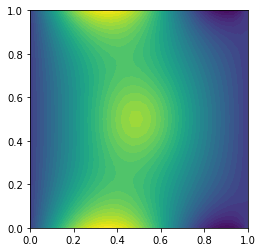

In [8]:
# Save solution in VTK format
file = File("poisson.pvd")
file << u

# Plot solution
import matplotlib.pyplot as plt
plot(u)
plt.show()